In [1]:
import numpy as np
import time
from numpy import *
from scipy import io

import matplotlib.pyplot as plt

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import PolynomialFeatures

import sys
sys.path.append("../")

from spline import splineBasis
from ado import * 

# make noisy and sparse data

In [2]:
sim_measurement = io.loadmat('../systems/Lorenz system/Lorenz_data.mat')['X']

x_sample = sim_measurement[:, 0]
y_sample = sim_measurement[:, 1]
z_sample = sim_measurement[:, 2]

t_m_all = np.linspace(0, 20, 2001)

n_ratio = 0.05 # noise level 

np.random.seed(0)

x_n = np.random.normal(0,1,len(t_m_all))
x_n = x_n / np.std(x_n)
x_noise = (x_sample + n_ratio * np.sqrt(np.mean(x_sample**2)) * x_n)[sub_idx]

y_n = np.random.normal(0,1,len(t_m_all))
y_n = y_n / np.std(y_n)
y_noise = (y_sample + n_ratio * np.sqrt(np.mean(y_sample**2)) * y_n)[sub_idx]

z_n = np.random.normal(0,1,len(t_m_all))
z_n = z_n / np.std(z_n)
z_noise = (z_sample + n_ratio * np.sqrt(np.mean(z_sample**2)) * z_n)[sub_idx]

# Physics-informed Spline Learning

build cubic B-spline model 

In [4]:
end_t = 20
num_control = 50*end_t+1
num_c = 1000*end_t+1

t = np.linspace(0, end_t, num_control)
knots = np.array([0,0,0] + list(t) + [end_t,end_t,end_t])

sub_idx = [int(x) for x in np.linspace(0, 2000, 401)] # downsample
t_m = t_m_all[sub_idx]

t_c = np.array(sorted(list(t_m) + list(np.random.rand(num_c-len(t_m))*end_t)))

basis = splineBasis(knots, t_m, t_c)
basis_m, basis_dt_m = basis.get_measurement()
basis_c, basis_dt_c = basis.get_collocation()

pre-training

In [7]:
poly_degree = 3

X = np.arange(poly_degree * 3).reshape(poly_degree, 3)
poly = PolynomialFeatures(poly_degree)
poly.fit_transform(X)
raw_poly = poly.get_feature_names(input_features=['x', 'y', 'z'])
polynomial_library = [p.replace(' ', '*').replace('^', '**') for p in raw_poly]

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

t_m_len = basis_m.shape[0]
t_c_len = basis_c.shape[0]
num_control = basis_m.shape[1]
num_term = len(polynomial_library)


# create a function that will be evaluated while training 
# this function is constructed with unknown parameters {cxi, cyi, czi}, i=0,1,....num_terms
function_x = ''
function_y = ''
function_z = ''

for i in range(num_term):
    term = polynomial_library[i]
    function_x += ('+cx'+str(i)+'*'+term)
    function_y += ('+cy'+str(i)+'*'+term)
    function_z += ('+cz'+str(i)+'*'+term)
    
function_x = function_x[1:]
function_y = function_y[1:]
function_z = function_z[1:]
    
# convert the basis matrices to tensors 
N = torch.Tensor(basis_m).to(device)
N_c = torch.Tensor(basis_c).to(device)
N_dt = torch.Tensor(basis_dt_c).to(device)

# convert the measurement data into tensor 
measurement = torch.Tensor(np.vstack([x_noise, y_noise, z_noise]).transpose()).to(device)

# define control points (one column for each variable)
P = torch.autograd.Variable(torch.rand(num_control, 3).to(device), requires_grad=True)

for i in range(num_term): 
    globals()['cx'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
    globals()['cy'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
    globals()['cz'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)

coef_lst = [globals()['cx'+str(i)] for i in range(num_term)] + \
           [globals()['cy'+str(i)] for i in range(num_term)] + \
           [globals()['cz'+str(i)] for i in range(num_term)]


# physics loss (denominator values known, calculate in the measurement domain)
def loss_phy(P):
    x = torch.matmul(N_c, P[:, 0])
    y = torch.matmul(N_c, P[:, 1])
    z = torch.matmul(N_c, P[:, 2])
    
    return (torch.norm(torch.matmul(N_dt, P[:, 0]) - eval(function_x), p=2) ** 2 +
            torch.norm(torch.matmul(N_dt, P[:, 1]) - eval(function_y), p=2) ** 2 + 
            torch.norm(torch.matmul(N_dt, P[:, 2]) - eval(function_z), p=2) ** 2) / t_c_len   

# data loss + physics loss
def loss_total(P):
    loss_p = loss_phy(P)
    loss_d = (torch.norm(torch.matmul(N, P[:, 0]) - measurement[:, 0], p=2) ** 2 + 
              torch.norm(torch.matmul(N, P[:, 1]) - measurement[:, 1], p=2) ** 2 +
              torch.norm(torch.matmul(N, P[:, 2]) - measurement[:, 2], p=2) ** 2) / t_m_len
    lossd_his.append(float(loss_d.cpu().detach().numpy()))
    lossp_his.append(float(loss_p.cpu().detach().numpy()))
    
    return loss_d + 0.01*loss_p

start_time = time.time()
    
# define learning rate and optimizer 
learning_rate = 0.01
optimizer = torch.optim.Adamax([P] + coef_lst,
                             lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0

lossd_his = []
lossp_his = []

for t in range(200000):
    optimizer.zero_grad()

    loss = loss_total(P)
    loss.backward()

    scheduler.step(loss)
    
    optimizer.step()

    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0

    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("Early stopping!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 199999:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("200,000 epochs completed!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))

Using device: cuda

epoch : 0 loss : 758.7601928710938 lr : 0.01
epoch : 5000 loss : 3.2425577640533447 lr : 0.01
epoch : 10000 loss : 3.036566734313965 lr : 0.01
epoch : 15000 loss : 2.750610113143921 lr : 0.001
epoch : 20000 loss : 2.7071444988250732 lr : 0.001
epoch : 25000 loss : 2.6693673133850098 lr : 0.001
epoch : 30000 loss : 2.644158363342285 lr : 0.001
epoch : 35000 loss : 2.624257802963257 lr : 0.001
epoch : 40000 loss : 2.615217685699463 lr : 0.001
epoch : 45000 loss : 2.6055476665496826 lr : 1e-05
epoch : 50000 loss : 2.602983236312866 lr : 1e-05
epoch : 55000 loss : 2.600287675857544 lr : 1e-05
epoch : 60000 loss : 2.597825050354004 lr : 1e-05
epoch : 65000 loss : 2.5955464839935303 lr : 1e-05
epoch : 70000 loss : 2.5934200286865234 lr : 1e-05
epoch : 75000 loss : 2.59142804145813 lr : 1e-05
epoch : 80000 loss : 2.5895450115203857 lr : 1e-05
epoch : 85000 loss : 2.5877649784088135 lr : 1e-05
epoch : 90000 loss : 2.5860769748687744 lr : 1e-05
epoch : 95000 loss : 2.5844707

x_dot : 0.015*1 - 0.966*x + 4.703*y + 0.506*z + 0.331*x**2 - 0.151*x*y - 0.419*x*z - 0.009*y**2 + 0.298*y*z - 0.058*z**2 + 0.021*x**3 + 0.008*x**2*y - 0.012*x**2*z - 0.025*x*y**2 + 0.006*x*y*z + 0.003*x*z**2 + 0.008*y**3 - 0.001*y**2*z - 0.005*y*z**2 + 0.001*z**3

y_dot : 1.289*1 + 4.949*x + 9.603*y + 0.452*z - 0.113*x**2 + 0.441*x*y + 0.228*x*z - 0.196*y**2 - 0.425*y*z - 0.072*z**2 - 0.026*x**3 + 0.036*x**2*y - 0.007*x**2*z - 0.025*x*y**2 - 0.003*x*y*z - 0.014*x*z**2 + 0.007*y**3 + 0.003*y**2*z + 0.002*y*z**2 + 0.002*z**3

z_dot : 6.752*1 + 0.063*x + 0.648*y - 0.14*z + 0.102*x**2 + 1.209*x*y - 0.214*x*z - 0.123*y**2 + 0.089*y*z - 0.218*z**2 - 0.033*x**3 + 0.042*x**2*y - 0.018*x**2*z - 0.016*x*y**2 + 0.009*x*y*z + 0.008*x*z**2 - 0.0*y**3 - 0.001*y**2*z - 0.003*y*z**2 + 0.005*z**3



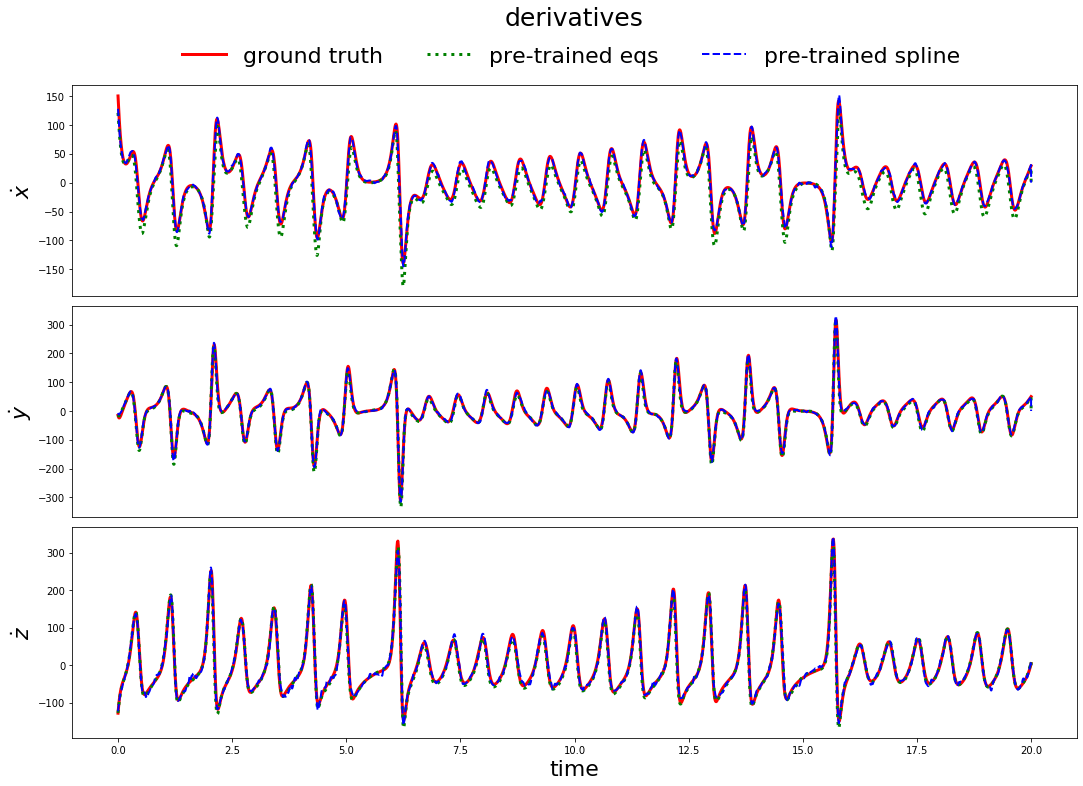

In [9]:
loss_pretuning = loss.item()

# prepare a copy of pre-tuned control points values 
P_pre = P.cpu().detach().numpy().copy()

# convert the pre-tuned equation parameters in matrix form 
lambda_raw = np.zeros([num_term, 3])

function_x = function_y = function_z = ''

for i in range(0, num_term):
    term = polynomial_library[i]
    if globals()['cx'+str(i)] in coef_lst:
        function_x += (' + '+str(np.round(globals()['cx'+str(i)].cpu().detach().numpy()[0], 3))+'*'+term)
        lambda_raw[i, 0] = globals()['cx'+str(i)].cpu().detach().numpy()[0]
    if globals()['cy'+str(i)] in coef_lst:
        function_y += (' + '+str(np.round(globals()['cy'+str(i)].cpu().detach().numpy()[0], 3))+'*'+term)
        lambda_raw[i, 1] = globals()['cy'+str(i)].cpu().detach().numpy()[0]
    if globals()['cz'+str(i)] in coef_lst:
        function_z += (' + '+str(np.round(globals()['cz'+str(i)].cpu().detach().numpy()[0], 3))+'*'+term)
        lambda_raw[i, 2] = globals()['cz'+str(i)].cpu().detach().numpy()[0]

# print pre-tuned equations 
print('x_dot :', function_x.replace('+ -', '- ')[3:])
print()
print('y_dot :', function_y.replace('+ -', '- ')[3:])
print()
print('z_dot :', function_z.replace('+ -', '- ')[3:])
print() 

true_x = '10*y - 10*x'
true_y = '28*x - x*z - y'
true_z = 'x*y - 8/3 * z'

x = x_sample
y = y_sample
z = z_sample

eq1_true = eval(true_x)
eq2_true = eval(true_y)
eq3_true = eval(true_z)

x = torch.matmul(N_c, P[:, 0]).cpu().detach().numpy()
y = torch.matmul(N_c, P[:, 1]).cpu().detach().numpy()
z = torch.matmul(N_c, P[:, 2]).cpu().detach().numpy()

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(311)
ax.set_title("derivatives", fontsize=25, pad=60)
ax.plot(t_m_all, eq1_true, c='r', lw=3, label='ground truth')
ax.plot(t_c, eval(function_x), ':', c='g', lw=3, label='pre-trained eqs')
ax.plot(t_c, np.matmul(basis_dt_c, P.cpu().detach().numpy()[:, 0]), '--', 
         c='b', lw=2, label='pre-trained spline')
ax.axes.xaxis.set_visible(False)
ax.set_ylabel('$\dot{x}$', fontsize=22)
plt.legend(fontsize=22, ncol=3, frameon=False, loc=(0.1,1.05))

ax = fig.add_subplot(312)
ax.plot(t_m_all, eq2_true, c='r', lw=3, label='Ground truth y')
ax.plot(t_c, eval(function_y), ':', c='g', lw=3, label='discovered eqs')
ax.plot(t_c, np.matmul(basis_dt_c, P.cpu().detach().numpy()[:, 1]), '--', 
         c='b', lw=2, label='PiSL-pretrained')
ax.set_ylabel('$\dot{y}$', fontsize=22)
ax.axes.xaxis.set_visible(False)

ax = fig.add_subplot(313)
ax.plot(t_m_all, eq3_true, c='r', lw=3, label='Ground truth z')
ax.plot(t_c, eval(function_z), ':', c='g', lw=3, label='discovered eqs')
ax.plot(t_c, np.matmul(basis_dt_c, P.cpu().detach().numpy()[:, 2]), '--', 
         c='b', lw=2, label='PiSL-pretrained')
ax.set_ylabel('$\dot{z}$', fontsize=22)
ax.set_xlabel('time', fontsize=22)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

ADO - sparsity tuning

In [48]:
loss_HY = []
loss_HY_min = 1000000

terms_HY = [num_term*3]

A_raw = lambda_raw.copy()
A_raw_HY = A_raw.copy()

P_HY_np = P_pre.copy()
P_HY = torch.autograd.Variable(torch.Tensor(P_HY_np).to(device), requires_grad=True)

diminish_coef = True
num_terms  = np.count_nonzero(A_raw)

tol = 0.1
d_tol = 0.01
lam = 1e-6 # ridge regularizer 
eta = 0.001 # l-0 penalty ratio
        
tol_best = [0, 0, 0]
        
start_time = time.time()

itr = 0

while diminish_coef or itr < 5:
    
    #############################################################################
    ################  ADO part1: refined training of Parameters #################
    
    print('itr:' + str(itr+1))
    print('Training parameters (STRidge):')
    
    
    x = torch.matmul(N_c, P_HY[:, 0]).cpu().detach().numpy()
    y = torch.matmul(N_c, P_HY[:, 1]).cpu().detach().numpy()
    z = torch.matmul(N_c, P_HY[:, 2]).cpu().detach().numpy()
    
    phi = np.zeros([t_c_len, num_term])
    for i in range(num_term):
        phi[:, i] = eval(polynomial_library[i].replace('torch.', ''))
        
    Y_spline = torch.matmul(N_dt, P_HY).cpu().detach().numpy()
    
    A_raw[:, 0], tol_best[0] = TrainSTRidge(phi, Y_spline[:, 0], lam, eta, d_tol, maxit = 500)
    A_raw[:, 1], tol_best[1] = TrainSTRidge(phi, Y_spline[:, 1], lam, eta, d_tol, maxit = 500)
    A_raw[:, 2], tol_best[2] = TrainSTRidge(phi, Y_spline[:, 2], lam, eta, d_tol, maxit = 500)
    
    print('best tolerance threshold is', tol_best)
    print('prune number of terms to', np.count_nonzero(A_raw))
    print()
            
            
    #################################################################
    ################  ADO part2: Brute Force traing #################
    
    print('Brute Force training:')
    
    function_x = function_y = function_z = ''
    sparse_c_lst = []
    for i in range(0, num_term):
        term = polynomial_library[i]
        if A_raw[i, 0]!= 0: 
            function_x += (' + cx'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cx'+str(i)])
        if A_raw[i, 1]!= 0: 
            function_y += (' + cy'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cy'+str(i)])
        if A_raw[i, 2]!= 0: 
            function_z += (' + cz'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cz'+str(i)])

    function_x = function_x[3:]
    function_y = function_y[3:]
    function_z = function_z[3:]

    learning_rate = 0.05
    optimizer = torch.optim.Adam([P_HY] + sparse_c_lst, lr=learning_rate)


    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.0001)

    min_loss = 10000
    epochs_no_improve = 0

    loss_his = []

    for t in range(20000):
        optimizer.zero_grad()

        loss = loss_total(P_HY)
        loss.backward()

        scheduler.step(loss)
        loss_his.append(loss.item())

        if loss.item() >= min_loss:
            epochs_no_improve += 1
        else:
            min_loss = loss.item()
            epochs_no_improve = 0

        if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.0001:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("Early stopping!")
            break

        if t % 5000 == 0:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])

        optimizer.step()

        if t == 19999:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("20,000 epochs completed!")
            
    for i in range(num_term):
        if A_raw[i, 0]!= 0: A_raw[i, 0] = globals()['cx'+str(i)].cpu().detach().numpy()[0]
        if A_raw[i, 1]!= 0: A_raw[i, 1] = globals()['cy'+str(i)].cpu().detach().numpy()[0]
        if A_raw[i, 2]!= 0: A_raw[i, 2] = globals()['cz'+str(i)].cpu().detach().numpy()[0]

    for i in range(A_raw.shape[0]):
        for j in range(A_raw.shape[1]):
            if abs(A_raw[i, j]) < tol:
                A_raw[i, j] = 0
        
    print('prune number of terms to', np.count_nonzero(A_raw))

    loss_HY.append(loss.item() + eta*np.count_nonzero(A_raw))
    terms_HY.append(np.count_nonzero(A_raw))    
    if loss_HY[-1] < loss_HY_min:
        A_raw_HY = A_raw.copy()
        loss_HY_min = loss_HY[-1]
        
    if np.count_nonzero(A_raw) < num_terms:
        num_terms = np.count_nonzero(A_raw)
    else:
        diminish_coef = False
    
        
    itr += 1
    print()
    function_x = function_y = function_z = ''

    for i in range(0, num_term):
        term = polynomial_library[i]
        if A_raw_HY[i, 0] != 0: function_x += (' + '+str(np.round(A_raw_HY[i, 0], 4))+'*'+term)
        if A_raw_HY[i, 1] != 0: function_y += (' + '+str(np.round(A_raw_HY[i, 1], 4))+'*'+term)
        if A_raw_HY[i, 2] != 0: function_z += (' + '+str(np.round(A_raw_HY[i, 2], 4))+'*'+term)
    print()
    print('x/=', function_x[3:].replace('+ -', '- '))
    print()
    print('y/=', function_y[3:].replace('+ -', '- '))
    print()
    print('z/=', function_z[3:].replace('+ -', '- '))
    print()

    
print('reach convergence of number of terms in governing equations!')
print("--- %s seconds ---" % (time.time() - start_time))
print()
print('final result :')
            
function_x = function_y = function_z = ''

for i in range(0, num_term):
    term = polynomial_library[i]
    if A_raw_HY[i, 0] != 0: function_x += (' + '+str(np.round(A_raw_HY[i, 0], 4))+'*'+term)
    if A_raw_HY[i, 1] != 0: function_y += (' + '+str(np.round(A_raw_HY[i, 1], 4))+'*'+term)
    if A_raw_HY[i, 2] != 0: function_z += (' + '+str(np.round(A_raw_HY[i, 2], 4))+'*'+term)
print()
print('x/=', function_x[3:].replace('+ -', '- '))
print()
print('y/=', function_y[3:].replace('+ -', '- '))
print()
print('z/=', function_z[3:].replace('+ -', '- '))
print()

itr:1
Training parameters (STRidge):


C:\Users\sun.fa\Desktop\research\PiSL\Utils_PiSL_Lorenz.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
C:\Users\sun.fa\Desktop\research\PiSL\Utils_PiSL_Lorenz.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X.T.dot(X) + lam * np.eye(d), X.T.dot(y))[0]
C:\Users\sun.fa\Desktop\research\PiSL\Utils_PiSL_Lorenz.py:166: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input ma

best tolerance threshold is [0.12389586139273982, 0.02, 0.022360939431396786]
prune number of terms to 10

Brute Force training:
epoch : 0 loss : 483.93206787109375 lr : 0.05
epoch : 5000 loss : 2.645251512527466 lr : 0.05
epoch : 8558 loss : 2.579690933227539 lr : 0.0001
Early stopping!
prune number of terms to 9


x/= -0.4717*1 - 10.0339*x + 10.005*y

y/= 27.084*x - 0.1968*y - 0.9751*x*z

z/= -0.1733*1 - 2.6561*z + 0.9949*x*y

itr:2
Training parameters (STRidge):
best tolerance threshold is [4.999999999999938, 0.04, 0.9947580598656913]
prune number of terms to 7

Brute Force training:
epoch : 0 loss : 2.9458742141723633 lr : 0.05
epoch : 1442 loss : 2.580411672592163 lr : 0.0001
Early stopping!
prune number of terms to 7


x/= -10.0589*x + 10.0201*y

y/= 28.1625*x - 0.9987*y - 1.0087*x*z

z/= -2.661*z + 0.9941*x*y

itr:3
Training parameters (STRidge):
best tolerance threshold is [4.999999999999938, 0.9618127644130611, 0.9939296724865113]
prune number of terms to 6

Brute Force traini

post-tuning

In [50]:
# choose a tuning result from above
A_raw_post = A_raw_HY.copy()

function_x = function_y = function_z = ''
sparse_c_lst = []
for i in range(0, num_term):
    term = polynomial_library[i]
    if A_raw_post[i, 0]!= 0: 
        function_x += (' + cx'+str(i)+'*'+term)
        globals()['cx'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
        sparse_c_lst.append(globals()['cx'+str(i)])
    if A_raw_post[i, 1]!= 0: 
        function_y += (' + cy'+str(i)+'*'+term)
        globals()['cy'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
        sparse_c_lst.append(globals()['cy'+str(i)])
    if A_raw_post[i, 2]!= 0: 
        function_z += (' + cz'+str(i)+'*'+term)
        globals()['cz'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
        sparse_c_lst.append(globals()['cz'+str(i)])
        
function_x = function_x[3:]
function_y = function_y[3:]
function_z = function_z[3:]

learning_rate = 0.05
optimizer = torch.optim.Adam([P] + sparse_c_lst, lr=learning_rate)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.0001)

min_loss = 10000
epochs_no_improve = 0

loss_his = []

start_time = time.time()

for t in range(50000):
    optimizer.zero_grad()
    
    loss = loss_total(P)
    loss.backward()
    
    scheduler.step(loss)
    loss_his.append(loss.item())
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.0001:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("Early stopping!")
        print("--- %s seconds ---" % (time.time() - start_time))
        break

    if t % 1000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    optimizer.step()
    
    if t == 49999:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("50,000 epochs completed!")
        print("--- %s seconds ---" % (time.time() - start_time))
        
for i in range(0, num_term):
    if A_raw_post[i, 0]!= 0: 
        function_x = function_x.replace('cx'+str(i), str(np.round(globals()['cx'+str(i)].cpu().detach().numpy()[0], 4)))
    if A_raw_post[i, 1]!= 0: 
        function_y = function_y.replace('cy'+str(i), str(np.round(globals()['cy'+str(i)].cpu().detach().numpy()[0], 4)))
    if A_raw_post[i, 2]!= 0: 
        function_z = function_z.replace('cz'+str(i), str(np.round(globals()['cz'+str(i)].cpu().detach().numpy()[0], 4)))

print('----- final result -----')
print()
print('x_dot :', function_x.replace('+ -', '- ').replace('torch.', ''))
print()
print('y_dot :', function_y.replace('+ -', '- ').replace('torch.', ''))
print()
print('z_dot :', function_z.replace('+ -', '- ').replace('torch.', ''))
print()

epoch : 0 loss : 137.2161865234375 lr : 0.05
epoch : 1000 loss : 3.8505115509033203 lr : 0.05
epoch : 2000 loss : 3.0093700885772705 lr : 0.05
epoch : 3000 loss : 2.6126301288604736 lr : 0.05
epoch : 4000 loss : 2.5809056758880615 lr : 0.05
epoch : 4789 loss : 2.5804507732391357 lr : 0.0001
Early stopping!
--- 52.070085287094116 seconds ---
----- final result -----

x_dot : -10.0638*x + 10.0254*y

y_dot : 28.104*x - 0.9833*y - 1.0072*x*z

z_dot : -2.6619*z + 0.9943*x*y



# baseline: pySINDy

In [10]:
from pysindy import SINDy

x_sindy = np.vstack([x_noise, y_noise, z_noise]).T

model = SINDy(feature_names=['x', 'y', 'z'])
model.fit(x_sindy, t_m[1]-t_m[0])
model.print()

x' = -0.456 1 + -9.177 x + 9.168 y
y' = 22.323 x + 0.146 y + -0.846 x z
z' = 6.043 1 + -2.827 z + 0.151 x^2 + 0.813 x y
